# Data Preparation for X and y
No need to run these two cells. Here, the DataFrame for X and y has been constructed using a better method compared to Milestone2, and the result has been stored as a NumPy array.

In [122]:
%%time
import numpy as np
import pandas as pd


# Load the followers data which contains 'user_id' and 'podcaster_id'
followers = pd.read_csv('/Users/marzie/Documents/Data/my_followers_df')
# Create a set of tuples (user_id, podcaster_id) to represent the relationships
user_podcaster_set = set(zip(followers['user_id'], followers['podcaster_id']))

# Load the test users data and set 'user_id' as the index
test_users_df = (pd.read_csv('test_users_df.csv')).set_index('user_id')
test_user_ids = np.array(test_users_df.index)

# Load the train users data and set 'user_id' as the index
train_users_df = (pd.read_csv('train_users_df.csv')).set_index('user_id')
train_user_ids = np.array(train_users_df.index)

# Extract unique podcaster IDs for users in train_user_ids
podcater_ids = (followers[followers['user_id'].isin(train_user_ids)])['podcaster_id'].unique()

# Load sample test and train data
sample_test_users = np.load('sample_test_users.npy')
sample_test_podcasters = np.load('sample_test_podcasters.npy')
sample_tarin_user = np.load('sample_tarin_user.npy')
sample_train_podcasters = np.load('sample_train_podcasters.npy')

# Create pairs of (user_id, podcaster_id) to check in the test set
test_pairs_to_check = set(zip(test_user_ids[sample_test_users], podcater_ids[sample_test_podcasters]))
test_pairs = list(test_pairs_to_check)
test_podcater_index = np.array([np.where(podcater_ids==pair[1])[0][0] for pair in test_pairs])

# Create labels for the test pairs, 1 if the pair exists in user_podcaster_set, else 0
test_labels = np.array([1 if pair in user_podcaster_set else 0 for pair in test_pairs_to_check])
test_users_data = test_users_df.to_numpy().astype(int)

test_user_features = np.zeros((len(test_pairs), test_users_data.shape[1]))
# Populate the test user features array
for i, pair in enumerate(test_pairs):
    test_user_features[i] = test_users_data[np.where(test_user_ids==pair[0])[0][0]]

# Create pairs of (user_id, podcaster_id) to check in the train set
train_pairs_to_check = set(zip(train_user_ids[sample_tarin_user], podcater_ids[sample_train_podcasters]))
train_pairs = list(train_pairs_to_check)
train_podcater_index = np.array([np.where(podcater_ids==pair[1])[0][0] for pair in train_pairs])

# Create labels for the train pairs, 1 if the pair exists in user_podcaster_set, else 0
train_labels = np.array([1 if pair in user_podcaster_set else 0 for pair in train_pairs_to_check])
train_users_data = train_users_df.to_numpy().astype(int)

train_user_features = np.zeros((len(train_pairs), train_users_data.shape[1]))
# Populate the train user features array
for i, pair in enumerate(train_pairs):
    train_user_features[i] = train_users_data[np.where(train_user_ids==pair[0])[0][0]]

CPU times: user 2min 43s, sys: 1.08 s, total: 2min 45s
Wall time: 2min 45s


In [123]:
X_y_train = np.zeros((len(train_pairs), 10))
X_y_train[:, :8] = train_user_features
X_y_train[:, 8] = train_podcater_index
X_y_train[:, 9] = train_labels

X_y_test = np.zeros((len(test_pairs), 10))
X_y_test[:, :8] = test_user_features
X_y_test[:, 8] = test_podcater_index
X_y_test[:, 9] = test_labels

# np.save("X_y_train", X_y_train)
# np.save("X_y_test", X_y_test)

# Neural Network

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.metrics import Recall
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
X_y_train = np.load('X_y_train.npy')
X_y_test = np.load('X_y_test.npy')

print(f"The shape of the training data (X_y_train) is: {X_y_train.shape}")
print(f"The shape of the testing data (X_y_test) is: {X_y_test.shape}")

The shape of the training data (X_y_train) is: (999576, 10)
The shape of the testing data (X_y_test) is: (199928, 10)


In [3]:
X_y_train, X_y_val = train_test_split(X_y_train, test_size=0.2, random_state=42)

In [4]:
X_train = X_y_train[:, :-1]  # Features
X_test = X_y_test[:, :-1]  # Features
X_val = X_y_val[:, :-1]  # Features

y_train = X_y_train[:, -1]  # Labels
y_test = X_y_test[:, -1]  # Labels
y_val = X_y_val[:, -1]  # Labels

In [5]:
print(f'Average class probability in training set:   {y_train.mean():.4f}')
print(f'Average class probability in validation set: {y_val.mean():.4f}')
print(f'Average class probability in test set:       {y_test.mean():.4f}')

Average class probability in training set:   0.0069
Average class probability in validation set: 0.0069
Average class probability in test set:       0.0070


In [6]:
neg, pos = np.bincount(y_train.astype(int))
print(neg, pos)

794168 5492


In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train = np.clip(X_train, -5, 5)
X_val = np.clip(X_val, -5, 5)
X_test = np.clip(X_test, -5, 5)


print('Training labels shape:', y_train.shape)
print('Validation labels shape:', y_val.shape)
print('Test labels shape:', y_test.shape)
print()
print('Training features shape:', X_train.shape)
print('Validation features shape:', X_val.shape)
print('Test features shape:', X_test.shape)

Training labels shape: (799660,)
Validation labels shape: (199916,)
Test labels shape: (199928,)

Training features shape: (799660, 9)
Validation features shape: (199916, 9)
Test features shape: (199928, 9)


In [59]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
    
    model = keras.Sequential([
      keras.layers.Dense(8, activation='relu', input_shape=(X_train.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid'),
    ])

    model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

    return model

In [60]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',  # Monitor the validation Precision-Recall AUC (Area Under the Precision-Recall Curve)
    verbose=1,          # Verbosity mode, 1 = detailed messages
    patience=10,        # Number of epochs with no improvement after which training will be stopped
    mode='max',         # The mode to determine if we are looking for a maximum (max) of the monitored quantity
)

In [61]:
model = make_model()
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 8)                 80        
                                                                 
 dropout_10 (Dropout)        (None, 8)                 0         
                                                                 
 dense_17 (Dense)            (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


In [62]:
# Checking the model output for the first 10 samples in the training set
model.predict(X_train[:10])

1/1 [==============================] - 0s 44ms/step


array([[0.4164116 ],
       [0.6942512 ],
       [0.82085305],
       [0.8669241 ],
       [0.63848376],
       [0.97574997],
       [0.40435463],
       [0.4810673 ],
       [0.73686594],
       [0.4158698 ]], dtype=float32)

In [63]:
EPOCHS = 100
BATCH_SIZE = 10000
model = make_model()
baseline_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val))

Epoch 1/100
80/80 [==============================] - 1s 8ms/step - loss: 0.5261 - tp: 2230.0000 - fp: 169522.0000 - tn: 624646.0000 - fn: 3262.0000 - accuracy: 0.7839 - precision: 0.0130 - recall: 0.4060 - auc: 0.6364 - prc: 0.0138 - val_loss: 0.3190 - val_tp: 373.0000 - val_fp: 14279.0000 - val_tn: 184262.0000 - val_fn: 1002.0000 - val_accuracy: 0.9236 - val_precision: 0.0255 - val_recall: 0.2713 - val_auc: 0.6989 - val_prc: 0.0208
Epoch 2/100
80/80 [==============================] - 0s 2ms/step - loss: 0.3542 - tp: 1252.0000 - fp: 90305.0000 - tn: 703863.0000 - fn: 4240.0000 - accuracy: 0.8818 - precision: 0.0137 - recall: 0.2280 - auc: 0.5930 - prc: 0.0116 - val_loss: 0.1918 - val_tp: 36.0000 - val_fp: 829.0000 - val_tn: 197712.0000 - val_fn: 1339.0000 - val_accuracy: 0.9892 - val_precision: 0.0416 - val_recall: 0.0262 - val_auc: 0.6498 - val_prc: 0.0159
Epoch 3/100
80/80 [==============================] - 0s 2ms/step - loss: 0.2618 - tp: 668.0000 - fp: 47845.0000 - tn: 746323.0000 

80/80 [==============================] - 0s 3ms/step - loss: 0.0765 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 794168.0000 - fn: 5492.0000 - accuracy: 0.9931 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6587 - prc: 0.0122 - val_loss: 0.0341 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 198541.0000 - val_fn: 1375.0000 - val_accuracy: 0.9931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8617 - val_prc: 0.0357
Epoch 20/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0732 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 794168.0000 - fn: 5492.0000 - accuracy: 0.9931 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6688 - prc: 0.0125 - val_loss: 0.0337 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 198541.0000 - val_fn: 1375.0000 - val_accuracy: 0.9931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8680 - val_prc: 0.0372
Epoch 21/100
80/80 [==============================] - 0s 2ms/step - loss: 0.0704 - tp: 0.0000e+00 - f

Epoch 37/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0423 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 794168.0000 - fn: 5492.0000 - accuracy: 0.9931 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8338 - prc: 0.0242 - val_loss: 0.0307 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 198541.0000 - val_fn: 1375.0000 - val_accuracy: 0.9931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9095 - val_prc: 0.0557
Epoch 38/100
80/80 [==============================] - 0s 2ms/step - loss: 0.0415 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 794168.0000 - fn: 5492.0000 - accuracy: 0.9931 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8383 - prc: 0.0250 - val_loss: 0.0306 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 198541.0000 - val_fn: 1375.0000 - val_accuracy: 0.9931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9096 - val_prc: 0.0561
Epoch 39/100
80/80 [==============================] - 0s 2ms/step - loss: 0.0409 - tp: 0

Epoch 55/100
80/80 [==============================] - 0s 2ms/step - loss: 0.0362 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 794168.0000 - fn: 5492.0000 - accuracy: 0.9931 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8655 - prc: 0.0334 - val_loss: 0.0306 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 198541.0000 - val_fn: 1375.0000 - val_accuracy: 0.9931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8997 - val_prc: 0.0570
Epoch 56/100
80/80 [==============================] - 0s 2ms/step - loss: 0.0361 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 794168.0000 - fn: 5492.0000 - accuracy: 0.9931 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8666 - prc: 0.0337 - val_loss: 0.0306 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 198541.0000 - val_fn: 1375.0000 - val_accuracy: 0.9931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8993 - val_prc: 0.0566
Epoch 57/100
80/80 [==============================] - 0s 2ms/step - loss: 0.0360 - tp: 0

In [64]:
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    fig = plt.figure(figsize=(10, 7))
    rows = 2
    columns = 3
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

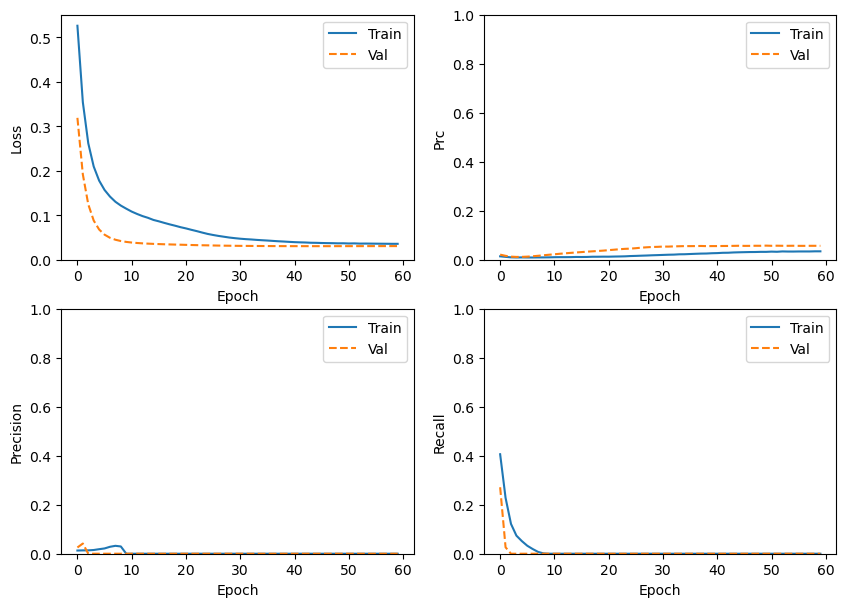

In [65]:
plot_metrics(baseline_history)

In [66]:
test_predictions_baseline = model.predict(X_test, batch_size=BATCH_SIZE)

20/20 [==============================] - 0s 767us/step


In [67]:
baseline_results = model.evaluate(X_test, y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

loss :  0.03017491288483143
tp :  0.0
fp :  0.0
tn :  198533.0
fn :  1395.0
accuracy :  0.9930225014686584
precision :  0.0
recall :  0.0
auc :  0.9069504141807556
prc :  0.06021920591592789



#### The model performs poorly in detecting positives, possibly because of the imbalanced classes and our failure to select the appropriate features for the problem.

In [79]:
threshold = 0.5
y_predicted = ((test_predictions_baseline > threshold).astype(int)).flatten()
cm = confusion_matrix(y_test, y_predicted)
print(cm)

[[198533      0]
 [  1395      0]]


#### By decreasing the threshold, we attribute higher cost to false negatives.

In [80]:
threshold = 0.1
y_predicted = ((test_predictions_baseline > threshold).astype(int)).flatten()
cm = confusion_matrix(y_test, y_predicted)
print(cm)

[[197387   1146]
 [  1313     82]]


# Class weights

In a binary classification problem with highly imbalanced classes, where one class significantly outnumbers the other, one effective approach is to heavily weight the few examples available from the minority class. This can be achieved in Keras by assigning class weights, which directs the model to prioritize examples from the under-represented class, thereby ensuring more attention is given to them during training.

In [81]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (neg+pos / 2)
weight_for_1 = (1 / pos) * (neg+pos / 2)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.00
Weight for class 1: 145.10


In [82]:
weighted_model = make_model()

weighted_history = weighted_model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val),
    verbose=2,
    # The class weights go here
    class_weight=class_weight)

Epoch 1/100
80/80 - 2s - loss: 1.5202 - tp: 3717.0000 - fp: 426413.0000 - tn: 566288.0000 - fn: 3170.0000 - accuracy: 0.5702 - precision: 0.0086 - recall: 0.5397 - auc: 0.5705 - prc: 0.0079 - val_loss: 0.6213 - val_tp: 951.0000 - val_fp: 87918.0000 - val_tn: 110623.0000 - val_fn: 424.0000 - val_accuracy: 0.5581 - val_precision: 0.0107 - val_recall: 0.6916 - val_auc: 0.6683 - val_prc: 0.0115 - 2s/epoch - 20ms/step
Epoch 2/100
80/80 - 0s - loss: 1.3356 - tp: 4241.0000 - fp: 428452.0000 - tn: 365716.0000 - fn: 1251.0000 - accuracy: 0.4626 - precision: 0.0098 - recall: 0.7722 - auc: 0.6396 - prc: 0.0101 - val_loss: 0.5895 - val_tp: 1128.0000 - val_fp: 82390.0000 - val_tn: 116151.0000 - val_fn: 247.0000 - val_accuracy: 0.5866 - val_precision: 0.0135 - val_recall: 0.8204 - val_auc: 0.7670 - val_prc: 0.0187 - 178ms/epoch - 2ms/step
Epoch 3/100
80/80 - 0s - loss: 1.2328 - tp: 4583.0000 - fp: 411647.0000 - tn: 382521.0000 - fn: 909.0000 - accuracy: 0.4841 - precision: 0.0110 - recall: 0.8345 - 

Epoch 21/100
80/80 - 0s - loss: 0.7778 - tp: 5036.0000 - fp: 199448.0000 - tn: 594720.0000 - fn: 456.0000 - accuracy: 0.7500 - precision: 0.0246 - recall: 0.9170 - auc: 0.9021 - prc: 0.0494 - val_loss: 0.3518 - val_tp: 1263.0000 - val_fp: 38121.0000 - val_tn: 160420.0000 - val_fn: 112.0000 - val_accuracy: 0.8088 - val_precision: 0.0321 - val_recall: 0.9185 - val_auc: 0.9233 - val_prc: 0.0580 - 190ms/epoch - 2ms/step
Epoch 22/100
80/80 - 0s - loss: 0.7806 - tp: 5021.0000 - fp: 198483.0000 - tn: 595685.0000 - fn: 471.0000 - accuracy: 0.7512 - precision: 0.0247 - recall: 0.9142 - auc: 0.8999 - prc: 0.0465 - val_loss: 0.3461 - val_tp: 1259.0000 - val_fp: 37379.0000 - val_tn: 161162.0000 - val_fn: 116.0000 - val_accuracy: 0.8124 - val_precision: 0.0326 - val_recall: 0.9156 - val_auc: 0.9236 - val_prc: 0.0582 - 207ms/epoch - 3ms/step
Epoch 23/100
80/80 - 0s - loss: 0.7758 - tp: 5050.0000 - fp: 197443.0000 - tn: 596725.0000 - fn: 442.0000 - accuracy: 0.7525 - precision: 0.0249 - recall: 0.919

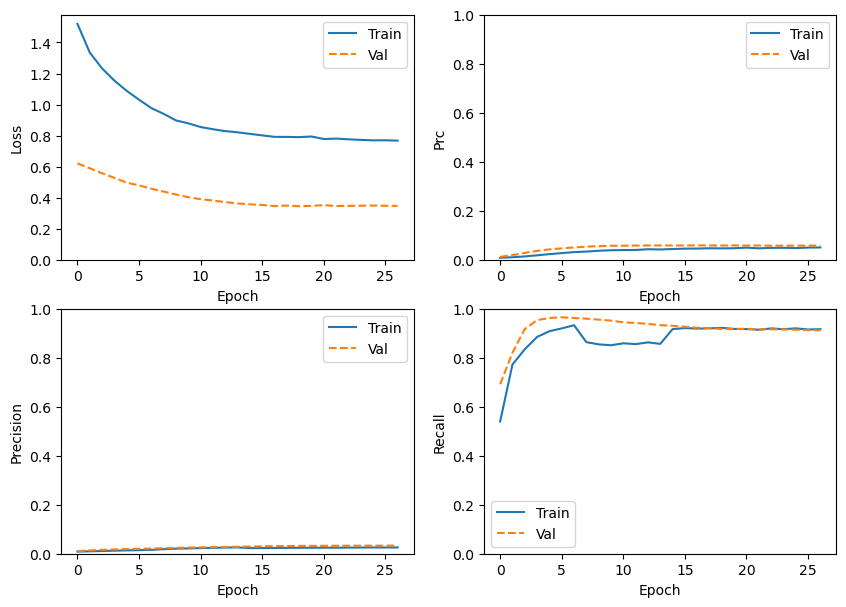

In [83]:
plot_metrics(weighted_history)

In [84]:
test_predictions_weighted = weighted_model.predict(X_test, batch_size=BATCH_SIZE)

20/20 [==============================] - 0s 881us/step


In [85]:
weighted_results = weighted_model.evaluate(X_test, y_test,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)
print()

y_predicted = ((test_predictions_weighted > 0.5).astype(int)).flatten()
cm = confusion_matrix(y_test, y_predicted)
print(cm)

loss :  0.3454568386077881
tp :  1291.0
fp :  36452.0
tn :  162081.0
fn :  104.0
accuracy :  0.8171541690826416
precision :  0.03420501947402954
recall :  0.9254480004310608
auc :  0.9308292865753174
prc :  0.06109575182199478

[[162081  36452]
 [   104   1291]]


# Oversampling

A related approach would be to resample the dataset by oversampling the minority class.

In [115]:
bool_train_labels = y_train.astype(bool)

pos_features = X_train[bool_train_labels]
neg_features = X_train[~bool_train_labels]

pos_labels = y_train[bool_train_labels]
neg_labels = y_train[~bool_train_labels]

In [116]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(794168, 9)

In [117]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(1588336, 9)

In [118]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
    ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
    ds = ds.shuffle(BUFFER_SIZE).repeat()
    return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [119]:
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2) 

In [120]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

159.0

In [121]:
resampled_model = make_model()

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/100
159/159 [==============================] - 95s 589ms/step - loss: 0.6510 - tp: 712367.0000 - fp: 442299.0000 - tn: 607874.0000 - fn: 337460.0000 - accuracy: 0.6287 - precision: 0.6169 - recall: 0.6786 - auc: 0.6915 - prc: 0.6522 - val_loss: 0.5513 - val_tp: 1285.0000 - val_fp: 67370.0000 - val_tn: 131171.0000 - val_fn: 90.0000 - val_accuracy: 0.6626 - val_precision: 0.0187 - val_recall: 0.9345 - val_auc: 0.8707 - val_prc: 0.0335
Epoch 2/100
159/159 [==============================] - 174s 1s/step - loss: 0.5349 - tp: 576469.0000 - fp: 248421.0000 - tn: 546646.0000 - fn: 218464.0000 - accuracy: 0.7064 - precision: 0.6988 - recall: 0.7252 - auc: 0.8019 - prc: 0.7653 - val_loss: 0.4655 - val_tp: 1330.0000 - val_fp: 59276.0000 - val_tn: 139265.0000 - val_fn: 45.0000 - val_accuracy: 0.7033 - val_precision: 0.0219 - val_recall: 0.9673 - val_auc: 0.9122 - val_prc: 0.0510
Epoch 3/100
159/159 [==============================] - 422s 3s/step - loss: 0.4767 - tp: 613243.0000 - fp: 21316

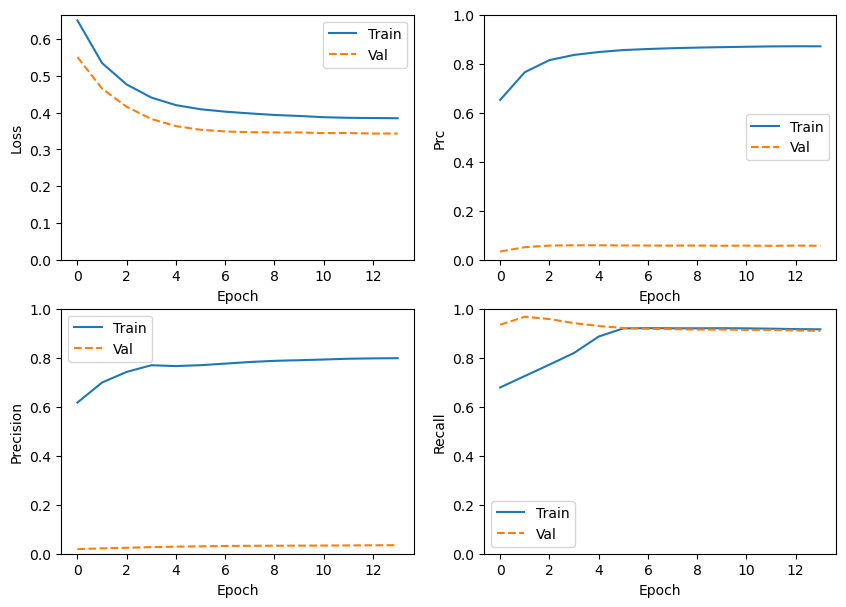

In [124]:
plot_metrics(resampled_history)

In [125]:
test_predictions_resampled = resampled_model.predict(X_test, batch_size=BATCH_SIZE)

20/20 [==============================] - 0s 673us/step


In [126]:
resampled_results = resampled_model.evaluate(X_test, y_test,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', value)
print()
y_predicted = ((test_predictions_resampled > 0.5).astype(int)).flatten()
cm = confusion_matrix(y_test, y_predicted)
print(cm)

loss :  0.34197288751602173
tp :  1282.0
fp :  34748.0
tn :  163785.0
fn :  113.0
accuracy :  0.8256322145462036
precision :  0.03558145835995674
recall :  0.9189963936805725
auc :  0.9308439493179321
prc :  0.06083326041698456

[[163785  34748]
 [   113   1282]]
